In [1]:
import jax.numpy as jnp
import jax.random as jr
import jax

In [31]:
# Create a function to make a boids simulation with toroidal space
def boids_simulation(num_boids, num_steps, seperation, separation_radius, alignment, cohesion, rng_key, space_size=10.0):
    """ 
    Simulate the movement of boids in a 2D toroidal space.
    
    Args:
        num_boids (int): Number of boids in the simulation.
        num_steps (int): Number of simulation steps.
        seperation (float): Weight for the separation behavior.
        alignment (float): Weight for the alignment behavior.
        cohesion (float): Weight for the cohesion behavior.
        rng_key (jax.random.PRNGKey): Random key for initialization.
        space_size (float): Size of the 2D toroidal space.

    Returns:
        position_history (jax.numpy.ndarray): History of positions at each step.
        velocity_history (jax.numpy.ndarray): History of velocities at each step.
        positions (jax.numpy.ndarray): Final positions of the boids.
        velocities (jax.numpy.ndarray): Final velocities of the boids.
    """
    # Initialize positions and velocities of boids
    positions = jr.uniform(rng_key, (num_boids, 2), minval=0.0, maxval=space_size)
    velocities = jr.uniform(rng_key, (num_boids, 2), minval=-0.1, maxval=0.1)
    
    def step(carry, _):
        positions, velocities = carry
        diff = positions[:, None, :] - positions[None, :, :]  # Pairwise differences
        distances = jnp.linalg.norm(diff, axis=-1)  # Pairwise distances
        mask = (distances < separation_radius) & (distances > 0)  # Neighborhood mask

        # Separation: Avoid nearby boids
        separation_vector = jnp.sum(jnp.where(mask[..., None], -diff, 0.0), axis=1)

        # Alignment: Match velocity with neighbors
        local_avg_velocity = jnp.sum(jnp.where(mask[..., None], velocities[None, :, :], 0.0), axis=1) / jnp.sum(mask, axis=1, keepdims=True)
        alignment_vector = local_avg_velocity - velocities

        # Cohesion: Move toward local center of mass
        local_center_of_mass = jnp.sum(jnp.where(mask[..., None], positions[None, :, :], 0.0), axis=1) / jnp.sum(mask, axis=1, keepdims=True)
        cohesion_vector = local_center_of_mass - positions

        # Update velocities
        velocities += (seperation * separation_vector +
                    alignment * alignment_vector +
                    cohesion * cohesion_vector) / num_boids

        # Normalize velocities
        velocities = velocities / (jnp.linalg.norm(velocities, axis=1, keepdims=True) + 1e-8)

        # Update positions
        positions += velocities

        # Apply toroidal wrapping
        positions = jnp.mod(positions, space_size)

        return (positions, velocities), (positions, velocities)
    
    # Use lax.scan to run the simulation for the specified number of steps
    (final_positions, final_velocities), (position_history, velocity_history) = jax.lax.scan(
        step, (positions, velocities), None, length=num_steps
    )
    
    return position_history, velocity_history, final_positions, final_velocities

In [41]:
# Example usage
num_boids = 300
num_steps = 1000
seperation = 0.1
alignment = 0.5
cohesion = 0.3
separation_radius = 2.0
rng_key = jr.PRNGKey(0)
# Run the simulation
position_history, velocity_history, final_positions, final_velocities = boids_simulation(
    num_boids, num_steps, seperation, separation_radius, alignment, cohesion, rng_key
)

In [42]:
# plot the positions and use the color for the velocities
import matplotlib.pyplot as plt
import numpy as np
# Convert JAX arrays to NumPy for plotting
position_history_np = jnp.array(position_history)
velocity_history_np = jnp.array(velocity_history)
abs_velocities = jnp.linalg.norm(velocity_history_np, axis=-1)
# Normalize the velocities for color mapping
velocity_history_np = (velocity_history_np - velocity_history_np.min()) / (velocity_history_np.max() - velocity_history_np.min())

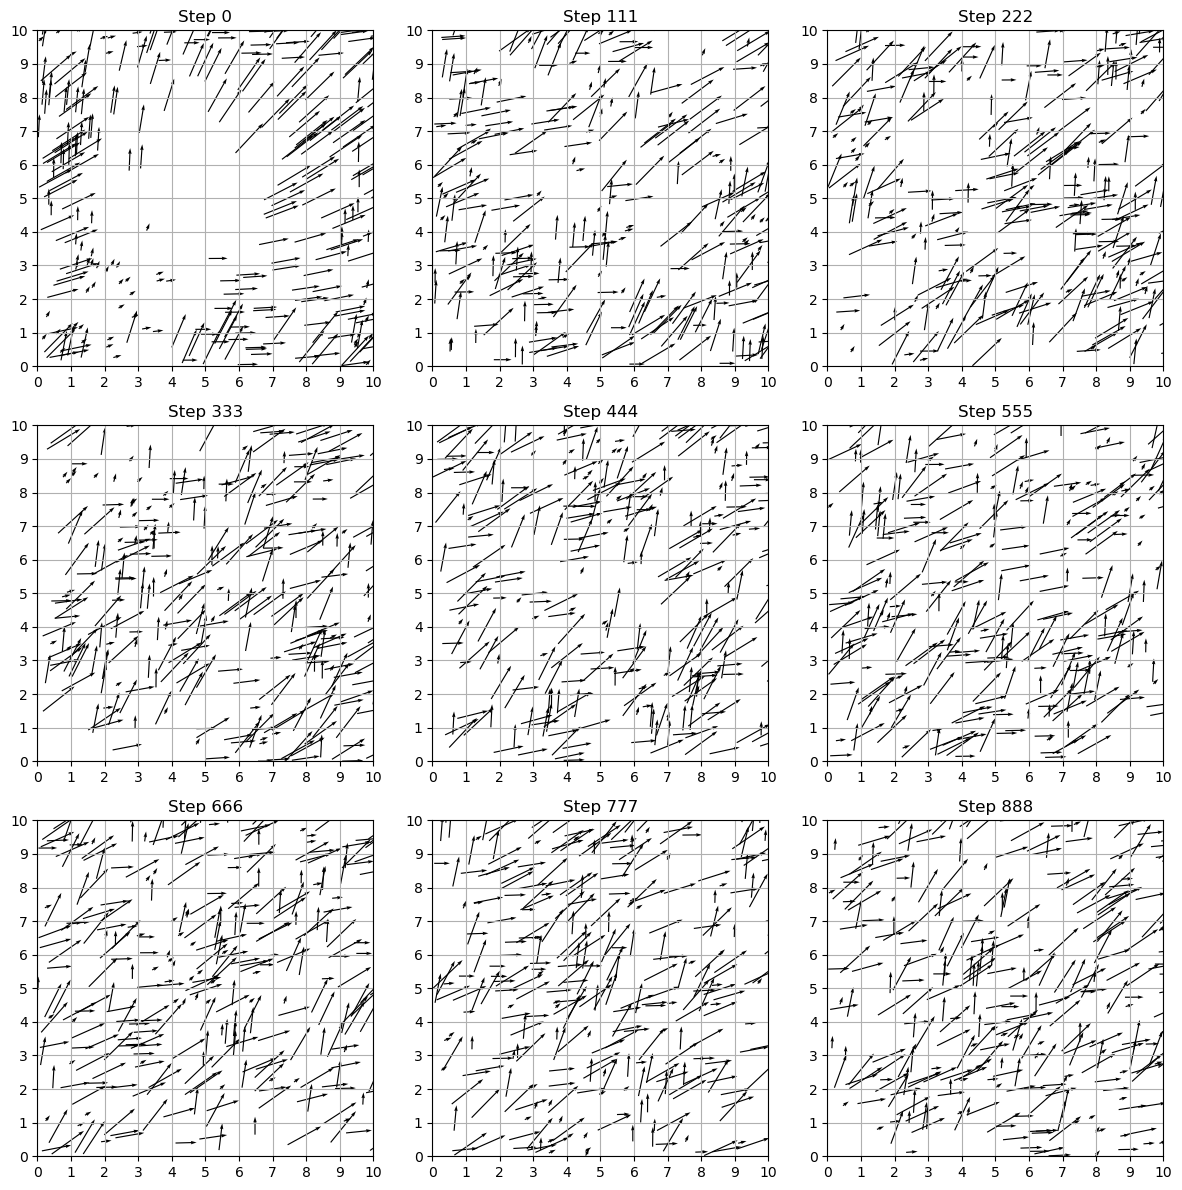

In [44]:
# Plot the simulation at 9 different time points in a 3x3 grid
use_velocity = True
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i, ax in enumerate(axs.flat):
    step = i * (num_steps // 9)
    ax.set_title(f"Step {step}")
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(0, 11, 1))
    ax.set_yticks(np.arange(0, 11, 1))
    ax.grid()
    # Plot the boids
    if use_velocity:
        ax.quiver(position_history_np[step, :, 0], position_history_np[step, :, 1],
                velocity_history_np[step, :, 0], velocity_history_np[step, :, 1],
                angles='xy', scale_units='xy', scale=1)
    else:
        ax.scatter(position_history_np[step, :, 0], position_history_np[step, :, 1], cmap='viridis', s=10)
plt.tight_layout()
plt.show()